# Sistema de Recomendación de Cultivos
## Entrega 2: Modelado Regresion Logistica vs Arbol de decision vs Random Forest

**Machine Learning**

**Profesor:** Marco Terán  
**Fecha:** 2025/10/22

**Integrantes**

- Daniel Alejandro Garcia Zuluaica
- Edward Alejandro Rayo Cortés
- Elizabeth Toro Chalarca

___

## 📋 Tabla de Contenidos

1. **Configuración del entorno**
2. **Carga de los datos**
3. **Preparacion de los datos**
4. **Comparativo Score Regresion logistica - Arbol de decision - Random Forest**

---

## 1. Configuración del Entorno

### ¿Por qué importan las versiones?

En ML, la reproducibilidad es crucial. Imagina que tu modelo funciona perfectamente en tu computadora pero falla en producción. La causa más común: diferentes versiones de librerías.

**Regla de oro**: Siempre documenta y verifica las versiones de tus dependencias.

### Librerías que usaremos

- **NumPy**: El motor matemático de Python. Maneja arrays y operaciones numéricas eficientemente
- **Pandas**: Como Excel con superpoderes. Organiza datos en DataFrames (tablas)
- **Matplotlib/Seaborn**: Nuestros artistas. Crean visualizaciones profesionales
- **Scikit-learn**: La navaja suiza del ML. Contiene algoritmos, métricas y utilidades

### Configuración visual

Los defaults de matplotlib no son los más bonitos. Vamos a configurar:
- Estilo consistente para todos los gráficos
- Tamaños legibles
- Colores agradables
- Formato de números apropiado

In [ ]:
# Configuración inicial del entorno
import sys
import warnings
warnings.filterwarnings('ignore')

# Verificar versión de Python
assert sys.version_info >= (3, 7), "Este notebook requiere Python 3.7 o superior"

print(f"✅ Python {sys.version_info.major}.{sys.version_info.minor} instalado correctamente")

✅ Python 3.12 instalado correctamente


## Importando Librerias

Descargarems las librerias necesarias para utilizar el modelo, esto solo se ejecuta una vez

In [ ]:
pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Validación de librerias

Se verifica que las librerias que vamos a usar estén completamente descargadas


- **NumPy**
- **Pandas**
- **Matplotlib/Seaborn**
- **Scikit-learn**

In [ ]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


#### Verificar versiones de librerías críticas
Se valida que tengamos la versión mínima de las librerias

In [ ]:

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1"), "Requiere scikit-learn >= 1.0.1"
print(f"✅ scikit-learn {sklearn.__version__} instalado")

✅ scikit-learn 1.7.2 instalado


In [ ]:
#importar funciones utilitarias implementads en el directorio src
import sys
sys.path.append('../src')

### Descarga y Carga de Datos

In [ ]:
# Función para descargar datos
import importlib
import data_loader
importlib.reload(data_loader)

from data_loader import load_crop_data

crop_data = load_crop_data()
print(crop_data.head())

📁 Cargando datos desde caché local: Crop_recommendation.csv
    N   P   K  temperature  humidity   ph  rainfall label
0  90  42  43        20.88     82.00 6.50    202.94  rice
1  85  58  41        21.77     80.32 7.04    226.66  rice
2  60  55  44        23.00     82.32 7.84    263.96  rice
3  74  35  40        26.49     80.16 6.98    242.86  rice
4  78  42  42        20.13     81.60 7.63    262.72  rice


In [ ]:
# Vista general del dataset
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATASET".center(80))
print("=" * 80)

# Mostrar primeras filas con formato mejorado
display(crop_data.head().style.background_gradient(cmap='coolwarm', subset=['temperature', 'humidity', 'ph', 'rainfall']))

# Información detallada
print("\n" + "=" * 80)
print("ESTRUCTURA DE DATOS".center(80))
print("=" * 80)
crop_data.info()

# Estadísticas descriptivas
print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS".center(80))
print("=" * 80)
display(crop_data.describe().round(2).T)

                        INFORMACIÓN GENERAL DEL DATASET                         


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice



                              ESTRUCTURA DE DATOS                               
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB

                           ESTADÍSTICAS DESCRIPTIVAS                            


,count,mean,std,min,25%,50%,75%,max
N,2200.00,50.55,36.92,0.00,21.00,37.00,84.25,140.00
P,2200.00,53.36,32.99,5.00,28.00,51.00,68.00,145.00
K,2200.00,48.15,50.65,5.00,20.00,32.00,49.00,205.00
temperature,2200.00,25.62,5.06,8.83,22.77,25.60,28.56,43.68
humidity,2200.00,71.48,22.26,14.26,60.26,80.47,89.95,99.98
ph,2200.00,6.47,0.77,3.50,5.97,6.43,6.92,9.94
rainfall,2200.00,103.46,54.96,20.21,64.55,94.87,124.27,298.56


## 2. Preparación de los Datos

### Limpieza (valores faltantes, outliers)

### Transformación (normalización, encoding)

### Creación de features (ingeniería de características)

### Selección de Caracteristicas relevantes

In [ ]:
# Visualización avanzada con Plotly: Heatmap de medias por clase

# Importar librerías
import pandas as pd
import plotly.express as px


# Calcular la media de cada característica numérica por clase (label)
mean_by_class = crop_data.groupby("label")[["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]].mean()

# Crear el heatmap
fig = px.imshow(
    mean_by_class,
    labels=dict(x="Características", y="Cultivo", color="Media"),
    x=mean_by_class.columns,
    y=mean_by_class.index,
    title="Heatmap de medias por clase de cultivo",
    aspect="auto",  # Ajusta la relación de aspecto
    text_auto=True  # Activa los valores dentro de las celdas
)

# Ajustar tamaño del gráfico
fig.update_layout(
    width=900,   # ancho
    height=1200, # alto
    margin=dict(l=100, r=100, t=100, b=100),
    title={
        'text': "Heatmap de medias por clase de cultivo",
        'x': 0.5,  # Centrado horizontal
        'xanchor': 'center',
        'font': {'size': 24, 'color': 'black', 'family': 'Arial'}
    }

)

# Mostrar el gráfico
fig.show()

Conclusion: El heatmap no sirve para medir relevancia predictiva, porque muestra medias por clase, no la capacidad de cada caracteristica para separar clases. Sin embargo da pistas, segun podriamos intuir que:

N, P, K: muestran variaciones fuertes entre cultivos → muy relevantes.
temperature, humidity, rainfall: también varían bastante → relevantes.
ph: suele ser más uniforme → menos relevante. 

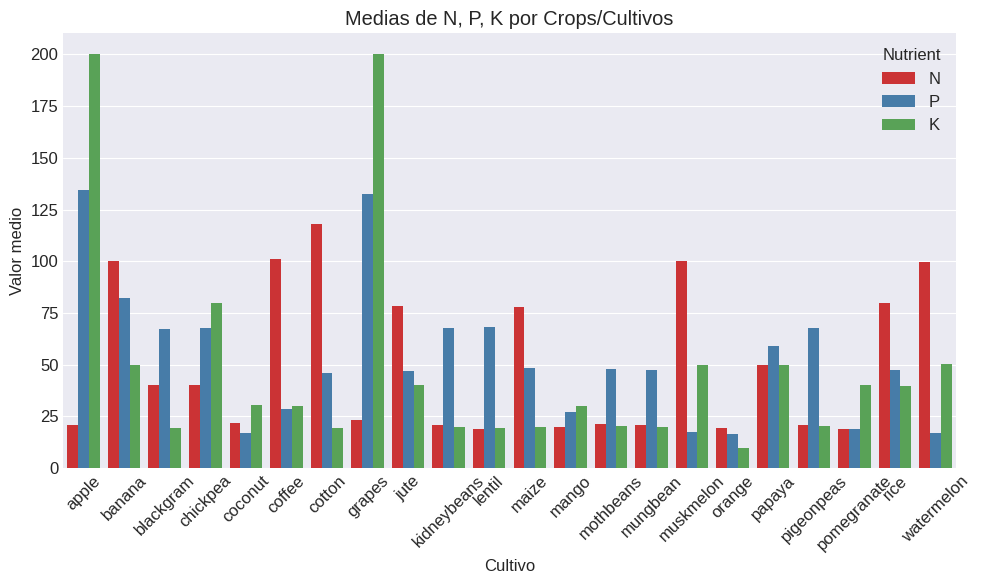

In [ ]:

group_npk = crop_data.groupby("label")[["N", "P", "K"]].mean().reset_index()
melted = group_npk.melt(id_vars="label", value_vars=["N", "P", "K"],var_name="Nutrient", value_name="Mean Value")

plt.figure(figsize=(10,6))
sns.barplot(x="label", y="Mean Value", hue="Nutrient", data=melted, palette="Set1")
plt.title("Medias de N, P, K por Crops/Cultivos")
plt.ylabel("Valor medio")
plt.xlabel("Cultivo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Este gráfico muestra las medias de N, P y K por cultivo, y un que tampoco sirve para medir relevancia predictiva, puedemos sacar algunas conclusiones útiles:

Diferencias claras entre cultivos
Algunos cultivos requieren mucho más N (nitrógeno) que otros. Por ejemplo, el primer cultivo (apple) tiene una barra roja muy alta para N.
Otros cultivos destacan por P (fósforo) o K (potasio), lo que indica necesidades específicas.

Variables relevantes
Si las barras para N, P y K varían significativamente entre cultivos, estas características son muy relevantes para predecir el tipo de cultivo.
En este gráfico, N, P y K muestran diferencias marcadas, son fuertes discriminadores.

Cultivos con perfiles únicos
Algunos cultivos tienen un perfil muy distinto (por ejemplo, uno con N muy alto y P/K bajos), lo que facilita la clasificación.
Otros cultivos con valores similares en N, P y K podrían ser más difíciles de diferenciar.

Implicación para el modelo
Variables con alta variabilidad entre clases (como N, P, K) son más útiles para modelos predictivos.
Si una variable fuera casi igual en todos los cultivos, sería poco relevante.

Ahora vamos a usarlos metodos ANOVA F-values, Mutual Information, Árbol de Decisión, para ver segun ellos cuales son las caractericas relevantes. 

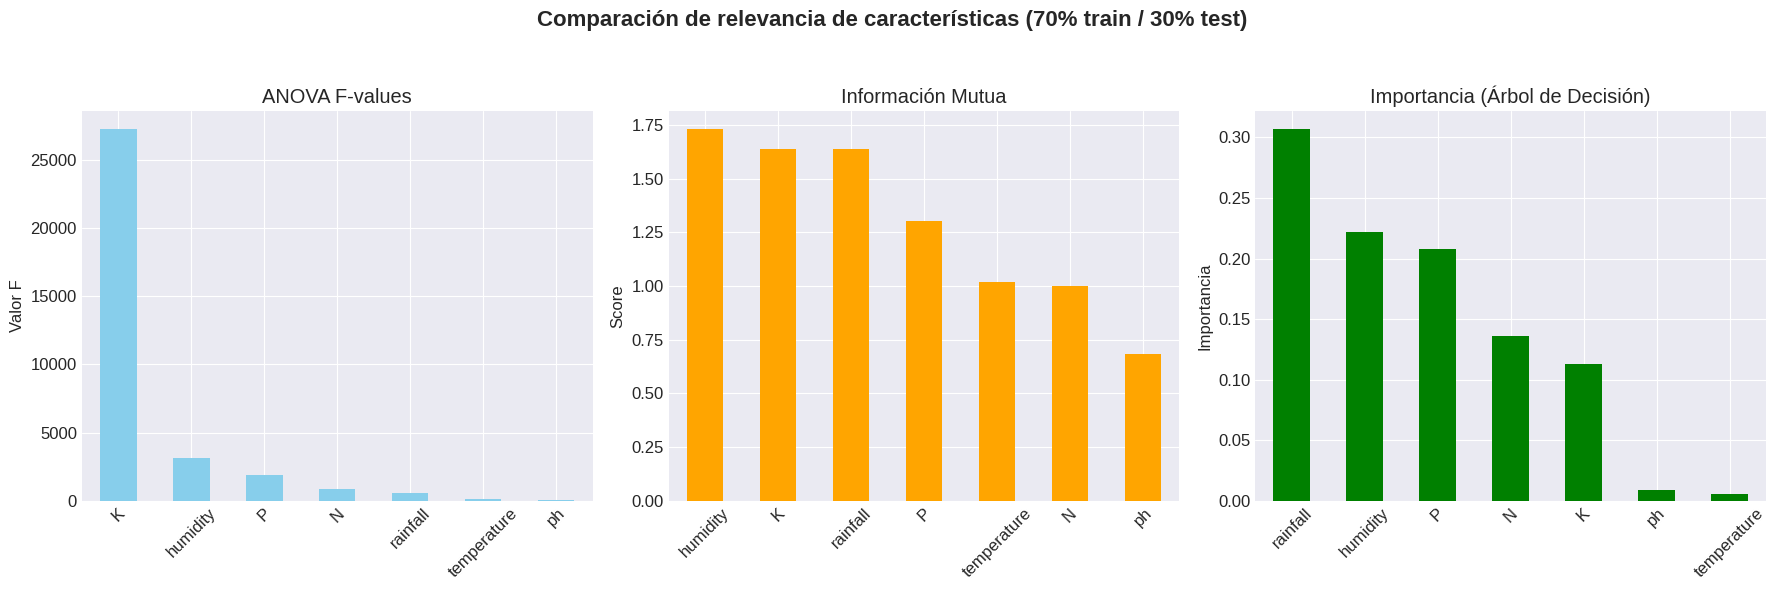

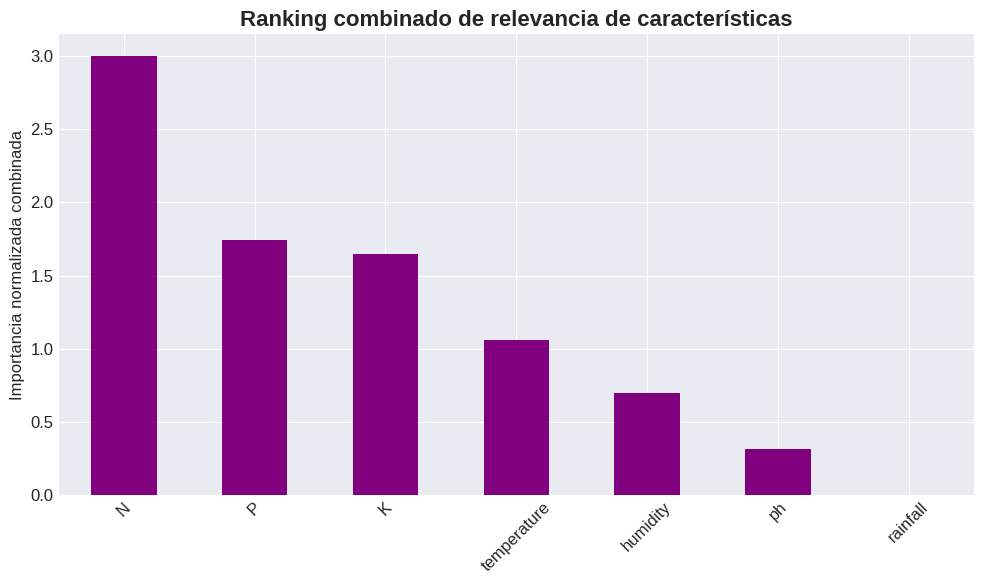

In [ ]:
# ============================================
# BLOQUE COMPLETO: ANÁLISIS DE RELEVANCIA DE CARACTERÍSTICAS
# Métodos: ANOVA F-values, Mutual Information, Árbol de Decisión
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


# Separar características (X) y variable objetivo (y)
X = crop_data.drop(columns=["label"])
y = crop_data["label"]

# ============================================
# MÉTODO 1: ANOVA F-values (usando datos de entrenamiento)
# ============================================
f_values, _ = f_classif(X, y)
f_scores = pd.Series(f_values, index=X.columns).sort_values(ascending=False)

# ============================================
# MÉTODO 2: Información Mutua (usando datos de entrenamiento)
# ============================================
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# ============================================
# MÉTODO 3: Importancia con Árbol de Decisión (entrenado en datos de entrenamiento)
# ============================================
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X, y)
tree_importances = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)

# ============================================
# GRÁFICO COMPARATIVO
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ANOVA
f_scores.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("ANOVA F-values")
axes[0].set_ylabel("Valor F")
axes[0].tick_params(axis='x', rotation=45)

# Información Mutua
mi_series.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title("Información Mutua")
axes[1].set_ylabel("Score")
axes[1].tick_params(axis='x', rotation=45)

# Árbol de Decisión
tree_importances.plot(kind='bar', ax=axes[2], color='green')
axes[2].set_title("Importancia (Árbol de Decisión)")
axes[2].set_ylabel("Importancia")
axes[2].tick_params(axis='x', rotation=45)

# Título general
plt.suptitle("Comparación de relevancia de características (70% train / 30% test)", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ============================================
# Normalización y ranking combinado
# ============================================
scaler = MinMaxScaler()
normalized_df = pd.DataFrame({
    "ANOVA_F": scaler.fit_transform(f_scores.values.reshape(-1, 1)).flatten(),
    "Mutual_Info": scaler.fit_transform(mi_series.values.reshape(-1, 1)).flatten(),
    "DecisionTree_Importance": scaler.fit_transform(tree_importances.values.reshape(-1, 1)).flatten()
}, index=X.columns)

# Calcular ranking combinado
normalized_df["Combined_Score"] = normalized_df.sum(axis=1)
combined_ranking = normalized_df["Combined_Score"].sort_values(ascending=False)

# ============================================
# Graficar ranking combinado
# ============================================
plt.figure(figsize=(10, 6))
combined_ranking.plot(kind='bar', color='purple')
plt.title("Ranking combinado de relevancia de características", fontsize=16, fontweight='bold')
plt.ylabel("Importancia normalizada combinada")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


1. ANOVA F-values

    K (Potasio) tiene un valor F extremadamente alto, indica que esta variable discrimina fuertemente entre clases.
    Humidity y P (Fósforo) también son relevantes, pero mucho menos que K.
    ph y temperature son las menos relevantes según este método.

2. Información Mutua

    Humidity, K y rainfall son las más informativas (alta dependencia con el target).
    ph sigue siendo la menos relevante.
    Este método muestra que la relación no es solo lineal, por eso rainfall aparece más importante aquí que en ANOVA.

3. Árbol de Decisión

    Rainfall es la característica más usada para dividir nodos (≈ 0.40).
    P y Humidity también son importantes.
    K, que era dominante en ANOVA, aquí tiene menor peso → indica que su relevancia depende del criterio del modelo.

4. Ranking combinado
    
    El modelo debería priorizar N, P y K como variables clave para la predicción.
    
    Variables como humidity, ph y rainfall podrían considerarse para reducción de dimensionalidad o menor peso en el modelo.


### 3. Comparativo Score para Regresion logistica - Arbol de decision - Random Forest*


In [ ]:
## modelado

# ============================================
# Librerías para análisis y modelado
# ============================================

# --- Manipulación y análisis de datos ---
import numpy as np
import pandas as pd
# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns
# --- Preprocesamiento y división de datos ---
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, LabelEncoder
# --- Metricas de evaluación ---
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
# --- Modelos de clasificación --- 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# Separar características y variable objetivo
X = crop_data.drop(columns=["label"])
y = crop_data["label"]

# División en 70% entrenamiento y 30% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Normalización de características para modelos sensibles a escala
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


# comparacion de modelos
models = {
    "Logistic_Regression": LogisticRegression(random_state=42),
    "Decision_Tree": DecisionTreeClassifier(random_state=42, max_depth=10),
    "RandomForest": RandomForestClassifier(random_state=42, n_estimators=100)
    }

fit_data = {
    "Logistic_Regression": (X_train_scaled, X_test_scaled),
    "Decision_Tree": (X_train, X_test),
    "RandomForest": (X_train, X_test)
}

score_results = {}
for model_name, model in models.items():
    Xtrain, Xtest = fit_data[model_name]
    model.fit(Xtrain, y_train) # entrenamiento
    y_train_pred = model.predict(Xtrain) # predicción en entrenamiento
    y_test_pred = model.predict(Xtest) # predicción en prueba
    
    score_results[model_name] = {
        "accuracy_entrenamiento": accuracy_score(y_train, y_train_pred),
        "acuracy_prueba": accuracy_score(y_test, y_test_pred),
        "classification_report_entrenamiento": classification_report(y_train, y_train_pred, output_dict=True),
        "classification_report_prueba": classification_report(y_test, y_test_pred, output_dict=True),
        "f1_score_entrenamiento": f1_score(y_train, y_train_pred, average='weighted'),
        "f1_score_prueba": f1_score(y_test, y_test_pred, average='weighted')
        }
# Mostrar resultados de accuracy y F1 Score
for model_name, scores in score_results.items():
    print(f"\nModelo: {model_name}")
    print(f"Accuracy (Entrenamiento): {scores['accuracy_entrenamiento']:.4f}")
    print(f"Accuracy (Prueba): {scores['acuracy_prueba']:.4f}")
    print(f"F1 Score (Entrenamiento - weighted): {scores['f1_score_entrenamiento']:.4f}")
    print(f"F1 Score (Prueba - weighted): {scores['f1_score_prueba']:.4f}")

#mostrar reportes de clasificación completos

# Crear tabla combinada
report_rows = []
for model_name, scores in score_results.items():
    for fase in ['entrenamiento', 'prueba']:
        report = scores[f'classification_report_{fase}']
        for clase, metricas in report.items():
            if isinstance(metricas, dict):  # evitar 'accuracy' que es un float
                report_rows.append({
                    'Modelo': model_name,
                    'Fase': fase,
                    'Clase': clase,
                    'Precision': metricas['precision'],
                    'Recall': metricas['recall'],
                    'F1-Score': metricas['f1-score'],
                    'Soporte': metricas['support']
                })

# Convertir a DataFrame y ordenar
df_report = pd.DataFrame(report_rows)
df_report_ordenado = df_report.sort_values(by=['Clase','Modelo', 'Fase'], ascending=[True, True, True])

# Mostrar tabla
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
#pd.set_option('display.width', None)        # Ajusta el ancho para no partir la tabla
print("\nClassification Report:")
print(df_report_ordenado.to_string(index=False))




Modelo: Logistic_Regression
Accuracy (Entrenamiento): 0.9747
Accuracy (Prueba): 0.9727
F1 Score (Entrenamiento - weighted): 0.9747
F1 Score (Prueba - weighted): 0.9725

Modelo: Decision_Tree
Accuracy (Entrenamiento): 0.9903
Accuracy (Prueba): 0.9803
F1 Score (Entrenamiento - weighted): 0.9901
F1 Score (Prueba - weighted): 0.9802

Modelo: RandomForest
Accuracy (Entrenamiento): 1.0000
Accuracy (Prueba): 0.9939
F1 Score (Entrenamiento - weighted): 1.0000
F1 Score (Prueba - weighted): 0.9939

Classification Report:
             Modelo          Fase        Clase  Precision  Recall  F1-Score  Soporte
      Decision_Tree entrenamiento        apple       1.00    1.00      1.00    70.00
      Decision_Tree        prueba        apple       1.00    1.00      1.00    30.00
Logistic_Regression entrenamiento        apple       1.00    1.00      1.00    70.00
Logistic_Regression        prueba        apple       1.00    1.00      1.00    30.00
       RandomForest entrenamiento        apple       1.00

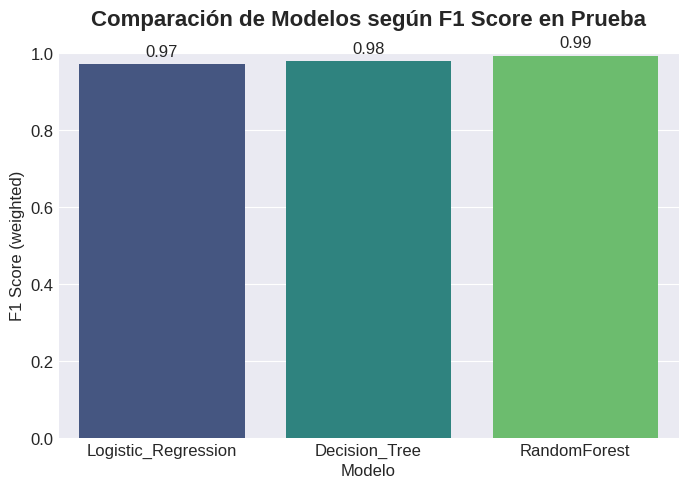


El mejor modelo es: RandomForest con F1 Score de 0.9939


In [ ]:
# Comparar modelos según F1 Score en prueba
f1_scores_prueba = {model_name: scores['f1_score_prueba'] for model_name, scores in score_results.items()}
plt.figure(figsize=(8, 5))
sns.barplot(x=list(f1_scores_prueba.keys()), y=list(f1_scores_prueba.values()), palette="viridis")
plt.title("Comparación de Modelos según F1 Score en Prueba", fontsize=16, fontweight='bold', pad=20)
plt.ylabel("F1 Score (weighted)")
plt.xlabel("Modelo")
plt.ylim(0, 1)
for i, v in enumerate(f1_scores_prueba.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)
plt.show()

mejor_modelo = max(f1_scores_prueba, key=f1_scores_prueba.get)
print(f"\nEl mejor modelo es: {mejor_modelo} con F1 Score de {f1_scores_prueba[mejor_modelo]:.4f}")

In [ ]:
#calcular algunas estadisticas adicionales

Xt = fit_data[mejor_modelo][1]  # Datos de prueba del mejor modelo
mmodel = models[mejor_modelo] # Mejor modelo entrenado
ypredit = mmodel.predict(Xt) # Predicciones del mejor modelo
names = sorted(crop_data["label"].unique())  # Lista ordenada de clases "y.unique()"

# Codificación de etiquetas para One-Hot Encoding
encoder = LabelEncoder()
encoder.fit(crop_data["label"])  # Ajusta con todas las clases
y_test_encoded = encoder.transform(y_test)


try :
    y_proba = mmodel.predict_proba(Xt)
    y_true_ovr = np.eye(len(names))[y_test_encoded]#len(names) = número de clases (en este caso, n) / np.eye(len(names)) = matriz identidad de tamaño n×n. [y_test] = selecciona las filas correspondientes a las clases reales, convirtiendo y_test en formato One-Hot Encoding.
    print("ROC-AUC Score (OvR):", roc_auc_score(y_true_ovr, y_proba, average='macro', multi_class='ovr'))

except Exception as ex:
    print(f"El modelo {model} no soporta predict_proba(): {ex}")
    

ROC-AUC Score (OvR): 0.9933261183261183
